In [1]:
import ROOT as root
import numpy as np

np.random.seed(1234)



Welcome to JupyROOT 6.14/04


In [2]:

def getDataFromFile(fileinfo, branchlist) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')
  datasize = tree.GetEntriesFast()
  
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    for branch in branchlist :
      data[counter][bridx] = getattr(entry, branch)
      bridx = bridx + 1

    counter = counter + 1
  
  tfil.Close()

  return data




def getDataFromFileWithCut(fileinfo, branchlist, cut_variable, cut_value) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')
  
  datasize = tree.GetEntries(cut_variable + " == " +  str(cut_value))
  
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    
    # check cut
    if getattr(entry, cut_variable) == cut_value :
    
      for branch in branchlist :
        data[counter][bridx] = getattr(entry, branch)
          
        bridx = bridx + 1
     
      counter = counter + 1
  
  tfil.Close()

  print " counter = ", counter 
  
  return data






def getDataFromFileWithCutGreater(fileinfo, branchlist, cut_variable, cut_value) :

  tfil = root.TFile(fileinfo)
  tree = tfil.Get('flatTree')

  datasize = tree.GetEntries(cut_variable + " >= " +  str(cut_value))
 
  print "Reading NN inputs from " + fileinfo
  data = np.empty([datasize, len(branchlist)])
  counter = 0
  for entry in tree :
    bridx = 0
    
    # check cut
    if getattr(entry, cut_variable) >= cut_value :
    
      for branch in branchlist :
        data[counter][bridx] = getattr(entry, branch)
        bridx = bridx + 1
     
      counter = counter + 1
  
  tfil.Close()

  print " counter = ", counter 
  
  return data


In [3]:

#######################################
#
# Start here
#

zllfile = 'flat_tree_Z.root'
 
# brlist  = ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3', 'tk_dedxl4', 'tk_dedxl5', 'tk_dedxl6']
# brlist  = ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3', 'tk_dedxl4']
brlist  = ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3']
numvars = len(brlist)
ntrain  =  0.50   # 80% for train
ntest   =  1 - ntrain

print " brlist = ", brlist
data_bkg = getDataFromFileWithCutGreater (zllfile, brlist, 'tk_category', 1 )

print " bkg data.size = " , data_bkg.size , " ---> ", data_bkg.size/numvars

datasize_bkg = data_bkg.size/numvars

print "Splitting data between " + str(int(len(data_bkg)*ntrain)) + " training and " + str(int(len(data_bkg)*ntest)) + " testing samples bkg ..."

data_bkg_train = data_bkg[ : int(len(data_bkg)*ntrain) ]
data_bkg_test  = data_bkg[ int(len(data_bkg)*ntrain) : ]

data_train = np.vstack( [ data_bkg_train] )
data_test  = np.vstack( [ data_bkg_test ] )


 brlist =  ['tk_dedxl0', 'tk_dedxl1', 'tk_dedxl2', 'tk_dedxl3', 'tk_dedxl4']
Reading NN inputs from flat_tree_Z.root
 counter =  70449
 bkg data.size =  352245  --->  70449
Splitting data between 35224 training and 35224 testing samples bkg ...


In [4]:
#
#
#
# Keras model
#
#

import matplotlib.pyplot as plt

from matplotlib import cm

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist

original_dim = numvars
intermediate_dim = 4
# latent_dim = 7    # one for each layer ?
latent_dim = 4    # one for each layer ?
batch_size = 100
epochs = 50
epsilon_std = 1.0




Using TensorFlow backend.


In [5]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)



In [6]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        print " mu = ", mu
        print " log_var = ", log_var
        
        
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [7]:

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [8]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#
# h intermediate step
#

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#
# from h -> 2 layers
#

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input (tensor = K.random_normal( stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim) ) )

z_eps = Multiply()([z_sigma, eps])
#
# Layer that multiplies (element-wise) a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

z = Add()([z_mu, z_eps])
#
# Layer that adds a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

x_pred = decoder(z)


In [9]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [10]:

# train the VAE 
x_train = data_train
x_test  = data_test


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 35224 samples, validate on 35225 samples
Epoch 1/50
35224/35224 [==============================] - 2s 52us/step - loss: -12.8355 - val_loss: -55.1655
Epoch 2/50
35224/35224 [==============================] - 2s 47us/step - loss: -96.3158 - val_loss: -120.9381
Epoch 3/50
35224/35224 [==============================] - 1s 42us/step - loss: -130.0552 - val_loss: -138.5054
Epoch 4/50
35224/35224 [==============================] - 2s 48us/step - loss: -144.8422 - val_loss: -150.0019
Epoch 5/50
35224/35224 [==============================] - 2s 47us/step - loss: -153.0080 - val_loss: -155.2886
Epoch 6/50
35224/35224 [==============================] - 2s 44us/step - loss: -156.5379 - val_loss: -157.8869
Epoch 7/50
35224/35224 [==============================] - 2s 46us/step - loss: -159.0625 - val_loss: -160.0643
Epoch 8/50
35224/35224 [==============================] - 2s 44us/step - loss: -160.4996 - val_loss: -160.9042
Epoch 9/50
35224/35224 [==============================] - 2s 44us

2018-12-17 17:56:58.362614: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [11]:
encoder = Model(x, z_mu)



In [12]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [13]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[ 1.72536969e-02 -1.02708936e-02 -6.80045784e-03 -1.47869396e+00]
 [-1.37091875e-02  1.10686719e-02 -1.94187462e-03  9.25725698e-03]
 [-1.52048767e-02  1.18866563e-02 -1.02801621e-03  1.07749701e-02]
 ...
 [ 6.72340393e-03  3.94496322e-03 -5.02169132e-04  1.52118647e+00]
 [-8.69864225e-03  8.32064450e-03 -4.97853756e-03  1.61314011e-03]
 [ 8.15731287e-03  3.15809250e-03 -1.34024024e-03  1.51905453e+00]]
x_test =  [[ 3.09220743  2.91992331  2.75642848  3.9106195   2.15135527]
 [ 2.30208063  2.25768137  4.39406109  2.08791327 -1.        ]
 [ 6.45768356  2.49957013  4.46570492  3.20503378 -1.        ]
 ...
 [ 3.21668196  2.88433599  2.30361819 -1.         -1.        ]
 [ 4.00258541  2.30555749  2.87209988  3.703614   -1.        ]
 [ 1.39788163  2.44209385  2.4899857  -1.         -1.        ]]


latent layer


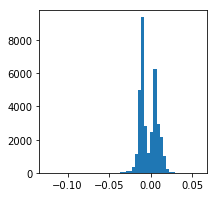

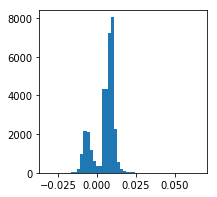

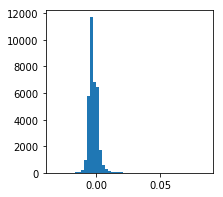

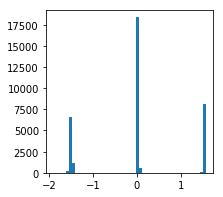

In [29]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)


print "latent layer"

for inode in range(latent_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




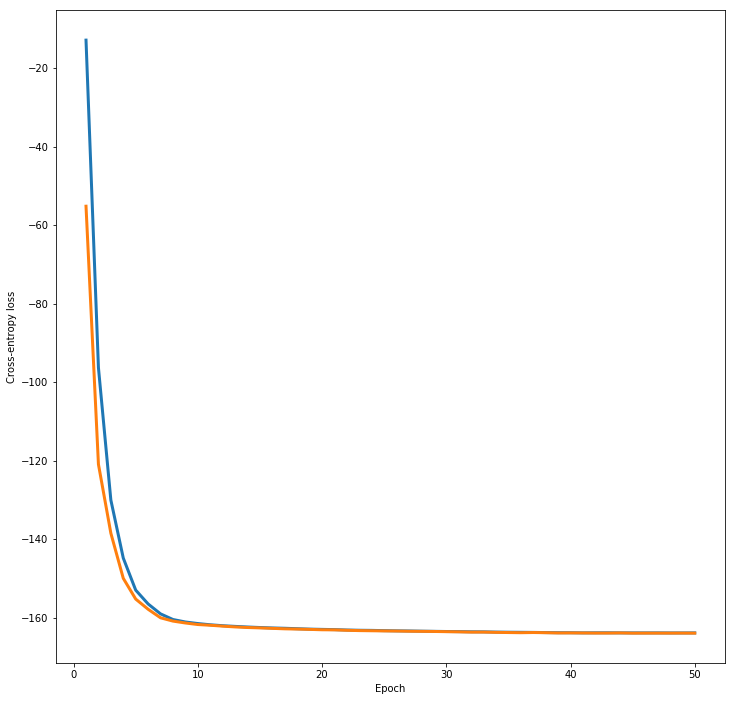

In [16]:


#########################################################
## validation plot

fig_validation = plt.figure(original_dim+latent_dim, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss");



In [17]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            24          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 4)            20          dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4)            20          dense_3[0][0]                    
__________________________________________________________________________________________________
kl_diverge

2D: reg vs original


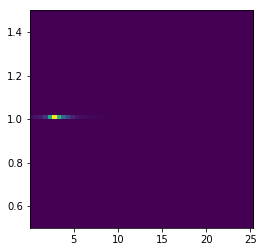

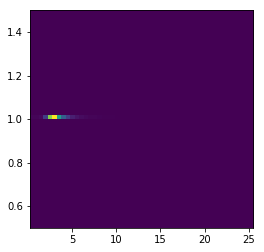

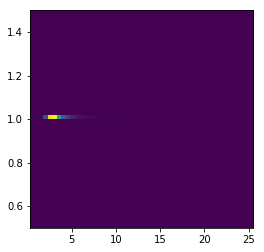

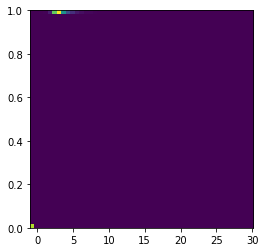

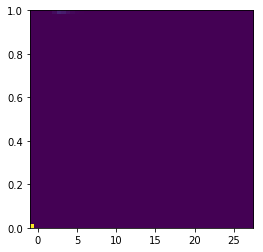

In [25]:
print "2D: reg vs original"

x_reg_test = vae.predict(x_test, batch_size = batch_size)

for inode in range(original_dim):
  fig = plt.figure(figsize = (4,4))
  plt.hist2d( x_test[:,inode], x_reg_test[:,inode], bins = 50)
    
    

input


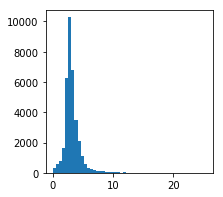

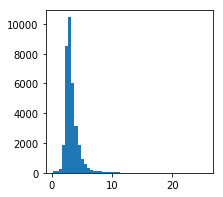

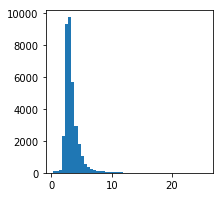

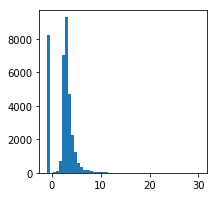

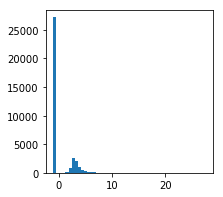

In [28]:

print "input"

for inode in range(original_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


output


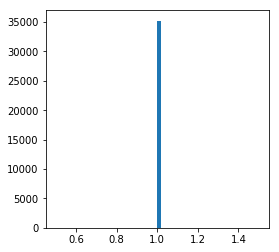

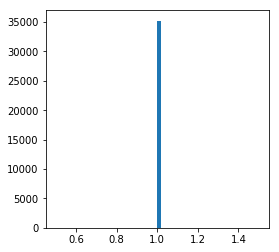

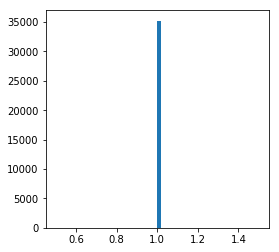

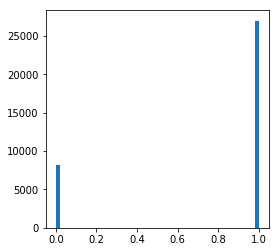

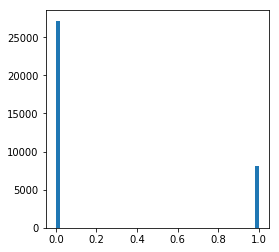

In [26]:
print "output"

for inode in range(original_dim):
   fig = plt.figure(figsize = (4,4))
   plt.hist( x_reg_test[:,inode], bins = 50)
